In [17]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, KFold

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../../")

from helpers.split import make_train_test_split, tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

DATASET_FOLDER = "../../../datasets/"

In [2]:
# read a data set
df = pd.read_pickle(DATASET_FOLDER + "dataset_01_mean.pickle")

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
pd.Series(y).value_counts()

7    5343
1    5276
9    4000
4    2126
5    1552
8     985
6     831
0     468
2     409
3     361
dtype: int64

In [5]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (21351, 13) y.shape= (21351,)


In [6]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=True, stratify=y, 
)

In [7]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (17080, 13)	y_train.shape = (17080,)
X_test.shape =  (4271, 13)	y_test.shape =  (4271,)


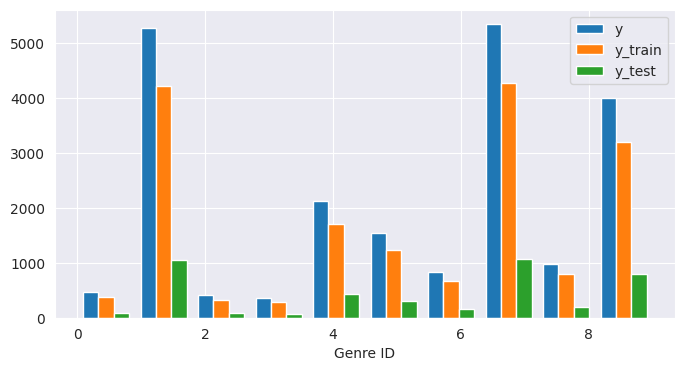

In [8]:
plt.figure(figsize=(8,4))
plt.hist([y, y_train, y_test],
         label=['y', 'y_train', 'y_test'])
plt.xlabel("Genre ID")
plt.legend()
plt.show()

In [9]:
scaler=StandardScaler()
#pca=KernelPCA(random_state=1962, n_components=200, n_jobs=-1)
#pca=PCA(random_state=1962, n_components=.85)
#pipe = Pipeline([('scaler', scaler),
#                 ('pca', pca)
#                ])

#No pipe -- just scale the features
pipe=scaler

In [10]:
# run the scaling/PCA extraction pipe
X_train_pca = pipe.fit_transform(X_train)
X_test_pca = pipe.transform(X_test)

In [11]:
# review the shapes
print(f"{X_train_pca.shape= } {X_test_pca.shape= }")

X_train_pca.shape= (17080, 13) X_test_pca.shape= (4271, 13)


In [12]:
# Use SMOTE or SMOTE variant to resample the training data

#smt = SMOTE (random_state=1962, n_jobs=-1)

#enn = EditedNearestNeighbours(kind_sel='mode', n_neighbors=3, n_jobs=-1)
#smt = SMOTEENN (random_state=1962, enn=enn)

#smt = SMOTETomek(random_state=1962, n_jobs=-1)

#X_train_resampled, y_train_resampled = smt.fit_resample(X_train_pca, y_train)

# Pass through, no resampling, this is our baseline
X_train_resampled, y_train_resampled = X_train_pca, y_train

In [13]:
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0  374]
 [   1 4221]
 [   2  327]
 [   3  289]
 [   4 1701]
 [   5 1241]
 [   6  665]
 [   7 4274]
 [   8  788]
 [   9 3200]]


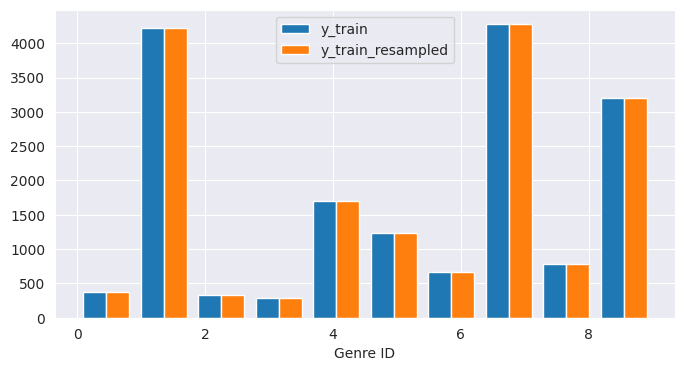

In [14]:
plt.figure(figsize=(8,4))
plt.hist([y_train, y_train_resampled],
         label=['y_train', 'y_train_resampled'])
plt.xlabel("Genre ID")
plt.legend()
plt.show()

**Preliminary Baseline**

In [15]:
model = XGBClassifier(
    use_label_encoder=False,
    tree_method='gpu_hist', 
    eta=.05,
    max_depth=6,
    reg_alpha=10,
    sampling_method='gradient_based',
    objective="multi:softprob", 
    eval_metric="mlogloss",
    seed=1962,
)

In [ ]:
# Let's just fit the model on our training data
model.fit(X_train_resampled, y_train_resampled)

In [16]:
scores = 
print("Mean train cross-validation mcc score: %.4f" % scores.mean())

Mean train cross-validation mcc score: 0.4203


In [ ]:
y_pred=model.predict(X_test_pca)

In [38]:
import json
import warnings

scoring=['matthews_corrcoef', 'f1_macro', 'accuracy', 'precision_macro', 'recall_macro']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores = cross_validate (model, X_train_resampled, y_train_resampled, scoring=scoring, cv=2, error_score=0)

scores

{'fit_time': array([1.79787016, 1.79496908]),
 'score_time': array([0.02035999, 0.02016592]),
 'test_matthews_corrcoef': array([0.41262651, 0.41483174]),
 'test_f1_macro': array([0.29201674, 0.2819408 ]),
 'test_accuracy': array([0.53255269, 0.53477752]),
 'test_precision_macro': array([0.40829651, 0.33648209]),
 'test_recall_macro': array([0.28448731, 0.28175604])}

In [39]:
{key.strip("test_"): value.mean() for key, value in scores.items() if "test" in key}

{'matthews_corrcoef': 0.41372912509972193,
 'f1_macro': 0.28697877151865614,
 'accuracy': 0.5336651053864169,
 'precision_macro': 0.3723892973468411,
 'recall_macro': 0.2831216743215845}

In [32]:
import json
json.dumps({key.strip("test_"): value.mean() for key, value in scores.items() if "test" in key})

'{"matthews_corrcoef": 0.41372912509972193, "f1_macro": 0.28697877151865614, "accuracy": 0.5336651053864169}'

In [ ]:
print(f"Training accuracy")
make_classification_report(
    y_train_resampled,
    model=model,
    x=X_train_resampled,
    digits=4,
    label_encoder=le,
    print_report=True,
    save_result=True,
    result_filename="rich_xgboost_results.json",
    model_name="XGBClassifier_baseline",
    dataset_name="dataset_00_all",
    phase="train",
    repeat=True,
    )
print(f"\nTesting accuracy")
make_classification_report(
    y_test,
    y_pred=y_pred,
    digits=4,
    label_encoder=le,
    print_report=True,
    save_result=True,
    result_filename="rich_xgboost_results.json",
    model_name="XGBClassifier_baseline",
    dataset_name="dataset_00_all",
    phase="test",
    repeat=True,
    )
pass

In [ ]:
dataset_name="Preliminary Baseline"
make_confusion_matrix(
    y_test,
    y_pred=y_pred,
    label_encoder=le,
    title=f"{dataset_name} test (row normalized)",
)
pass

**Optimized Model**

In [ ]:
model = XGBClassifier(
    
    learning_rate= 0.11484036953359722,
    gamma = 0.327162074525032, 
    max_depth = 8, 
    n_estimators = 427, 
    reg_alpha= 6.88045418099, 
    use_label_encoder=False,
    tree_method='gpu_hist', 
    sampling_method='gradient_based',
    objective="multi:softprob", 
    eval_metric="mlogloss",
    seed=1962,
)

In [ ]:
model.fit(X_train_resampled, y_train_resampled)

In [ ]:
scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                         scoring="matthews_corrcoef", cv=5,  n_jobs=-1, )
print("Mean train cross-validation mcc score: %.4f" % scores.mean())

In [ ]:
y_pred=model.predict(X_test_pca)

In [ ]:
print(f"Training accuracy")
make_classification_report(
    y_train_resampled,
    model=model,
    x=X_train_resampled,
    digits=4,
    label_encoder=le,
    print_report=True,
    save_result=True,
    result_filename="rich_xgboost_results.json",
    model_name="XGBClassifier_baseline_tuned",
    dataset_name="dataset_00_all",
    phase="train",
    repeat=True,
    )
print(f"\nTesting accuracy")
make_classification_report(
    y_test,
    y_pred=y_pred,
    digits=4,
    label_encoder=le,
    print_report=True,
    save_result=True,
    result_filename="rich_xgboost_results.json",
    model_name="XGBClassifier_baseline_tuned",
    dataset_name="dataset_00_all",
    phase="test",
    repeat=True,
    )
pass

In [ ]:
dataset_name="Optimized Baseline"
make_confusion_matrix(
    y_test,
    y_pred=y_pred,
    label_encoder=le,
    title=f"{dataset_name} test (row normalized)",
)
pass